# My Code

In [14]:
import sys
import tensorflow as tf
import random
import warnings
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import time

sys.path.append('../../Functions')
from STANDARD_FUNCTIONS import read_pickle
from TF_FUNCTIONS import df_to_LSTM, load_model
# from VISUALIZATION_FUNCTIONS import presentation_vs_poster

save_image = True

In [16]:
def presentation_vs_poster(style):

    global first_axs_col, second_axs_col, general_text_color, EDGE_color, FACECOLOR
    global small_font_size, medium_font_size, large_font_size, STYLE

    STYLE = style

    small_font_size = 14
    medium_font_size = 18
    large_font_size = 20

    if style.lower() == 'paper':
        
        # For most of the plots
        first_axs_col = 'slategray'
        second_axs_col = 'maroon'
        general_text_color = 'black'
        EDGE_color = 'black'
        FACECOLOR = "white"

    elif style.lower() == 'poster':
        
        # For most of the plots
        first_axs_col = 'beige'
        second_axs_col = 'cyan'
        general_text_color = 'white'
        EDGE_color = 'white'
        FACECOLOR = "#001543" # Dark Blue

    params = {"ytick.color": EDGE_color,
              "xtick.color": EDGE_color,
              'xtick.labelsize': small_font_size,
              'ytick.labelsize': small_font_size,
              "axes.labelcolor": EDGE_color,
              "axes.edgecolor": EDGE_color,
              "axes.titlecolor": EDGE_color,
              "font.size": '10',
              "font.family": "serif"}

    plt.rcParams.update(params)

## Importing Datasets

In [3]:
# import data:

WINDOW_SIZE = 457

input_data = read_pickle('/mnt/locutus/remotesensing/r62/river_ice_breakup/final_inputs/DAYMET_25_LOCATIONS_PRE_LSTM.pkl')
mins_and_maxes = read_pickle('/mnt/locutus/remotesensing/r62/river_ice_breakup/final_inputs/DAYMET_25_LOCATIONS_MINS_MAXES.pkl')
print(input_data.keys())

# importing training data
train_df = input_data['train_df']
train_dates = input_data['train_dates']
train_location = input_data['train_location']

# importing testing data
test_df = input_data['test_df']
test_locations = input_data['test_location'] 
test_dates = input_data['test_dates'] 
# test_X = df_to_LSTM(test_df, window_size=WINDOW_SIZE)

# importing model
model = load_model('/mnt/locutus/remotesensing/r62/river_ice_breakup/Results/DAYMET_25_LOCATIONS/Models/DAYMET/DAYMET_BAYESIAN')

# plot_data_test = pd.read_pickle('/mnt/locutus/remotesensing/r62/river_ice_breakup/Results/LOCATIONS_25/Output/DAYMET/Locations_25_DAYMET_plot_df.pkl')

dict_keys(['df', 'mask', 'train_df', 'val_df', 'test_df', 'train_y', 'val_y', 'test_y', 'train_dates', 'val_dates', 'test_dates', 'train_location', 'val_location', 'test_location', 'NOTES'])


2024-07-15 12:47:11.920260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/mpich-3.2/lib:/home/r62/anaconda3/lib:/home/r62/anaconda3/lib
2024-07-15 12:47:11.920355: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-15 12:47:11.920585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theseus.ornl.gov): /proc/driver/nvidia/version does not exist
2024-07-15 12:47:11.920914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with 

## We must aggregate over the locations

### First the test dataset

In [4]:
test_df['location'] = test_locations
column_names = list(test_df.columns)
column_names.pop(-1)

locations_data = []
for idx, subset in enumerate(test_df.groupby('location')):        
    DF = subset[1]
    DF.sort_index(inplace=True)
    DF.drop('location', axis=1, inplace=True)
    
    if idx == 0: # I noted that the first location is one of the shortest DFs
        # Else this would not work...
        index_to_match = DF.index
    
    DF = DF.loc[index_to_match]
    locations_data.append(np.array(DF))
    
locations_data = np.stack(locations_data)
locations_data = np.nanmean(locations_data, axis = 0) # averaging by location
locations_data = pd.DataFrame(locations_data)
locations_data.columns = column_names
locations_data.index = index_to_match
test_df_avg = locations_data
del locations_data

### Second the train dataset

In [5]:
train_df['location'] = train_location
column_names = list(train_df.columns)
column_names.pop(-1)

for idx, subset in enumerate(train_df.groupby('location')):        
    DF = subset[1]
    DF.sort_index(inplace=True)
    if idx == 19: # I noted that the last location is one of the shortest DFs
        # Else this would not work...
        index_to_match = DF.index
    
locations_data = []
for idx, subset in enumerate(train_df.groupby('location')):        
    DF = subset[1]
    DF.sort_index(inplace=True)
    DF.drop('location', axis=1, inplace=True)
    DF = DF.loc[index_to_match]
    DF[DF == -1] = np.nan # Here I have to remove the masked values
    locations_data.append(np.array(DF))
    
locations_data = np.stack(locations_data)
locations_data = np.nanmean(locations_data, axis = 0) # averaging by location
locations_data = pd.DataFrame(locations_data)
locations_data.columns = column_names
locations_data.index = index_to_match
train_df_avg = locations_data
del locations_data

# Plot Shapley Information

In [6]:
WINDOW_SIZE = 457
plot_data_vis = pd.read_pickle('/mnt/locutus/remotesensing/r62/river_ice_breakup/Results/DAYMET_25_LOCATIONS/Output/DAYMET/Locations_25_DAYMET_plot_df.pkl')

In [7]:
Predicted_Breakups = []
for idx, i in enumerate(plot_data_vis.groupby('sites')):
    DF = i[1]
    if idx == 0:
        keep_dates = DF.dates
    DF = DF[DF.dates.isin(keep_dates)]
    Predicted_Breakups.append(DF.Predicted_Breakup)
    
Predicted_Breakups = np.stack(Predicted_Breakups)
Predicted_Breakups = np.sum(Predicted_Breakups, axis = 0)[WINDOW_SIZE*2:]
Predicted_Breakups.shape

(2006,)

In [8]:
non_bias_shap_values = np.load('/mnt/locutus/remotesensing/r62/river_ice_breakup/Results/DAYMET_25_LOCATIONS/Output/Shapley_Analysis/shapley_values.npy')
non_bias_shap_values.shape

(2006, 15)

In [9]:
directory = '/mnt/locutus/remotesensing/r62/river_ice_breakup/Results/DAYMET_25_LOCATIONS/Output/Shapley_Analysis/'
files = []
for i in range(15):
    files.append(np.load(f'{directory}/shapley_values_column_{i}.npy'))
shap_values = np.stack(files).T
del files
shap_values = shap_values[WINDOW_SIZE:]

plot_df = test_df_avg.iloc[WINDOW_SIZE*2:, :]
plot_df.shape

(2006, 15)

In [10]:
shap_columns = [f'{i}_shap_value' for i in plot_df.columns]
shap_values = pd.DataFrame(shap_values)
shap_values.columns = shap_columns

non_bias_shap_values = pd.DataFrame(non_bias_shap_values)
non_bias_shap_values.columns = [f'{i}_NB' for i in shap_columns]

plot_df = plot_df.reset_index(drop=False)
shap_values = shap_values.reset_index(drop=True)

plot_df = pd.concat([plot_df, shap_values], axis = 1)
plot_df['Predicted_Dates'] = Predicted_Breakups
plot_df.rename(columns={'index': 'dates'}, inplace = True)

### Two options for which vars you want to plot

In [11]:
# variables_in_question = ['dayl(s)', 'prcp(mm/day)', 'srad(W/m^2)',
#        'swe(kg/m^2)', 'tmax(deg c)', 'tmin(deg c)', 'vp(Pa)', 'water_frac',
#        'twi_mean', 'perimeter', 'gravelius', 'cslope_mea', 'COS_Radians',
#        'SIN_Radians',]

variables_in_question = ['prcp(mm/day)', 'srad(W/m^2)',
       'swe(kg/m^2)', 'tmax(deg c)', 'tmin(deg c)', 'vp(Pa)',]

variable_names = ['Precipitation', 'Shortwave Radiation', 'Snow Water Equivalent', 'Maximum Temperature', 'Minimum Temperature', 'Vapor Pressure']

plot_df = pd.concat([plot_df, non_bias_shap_values], axis = 1)

In [12]:
plot_df.to_csv('/mnt/locutus/remotesensing/r62/river_ice_breakup/Results/DAYMET_25_LOCATIONS/Output/DAYMET/shapley_values.csv')

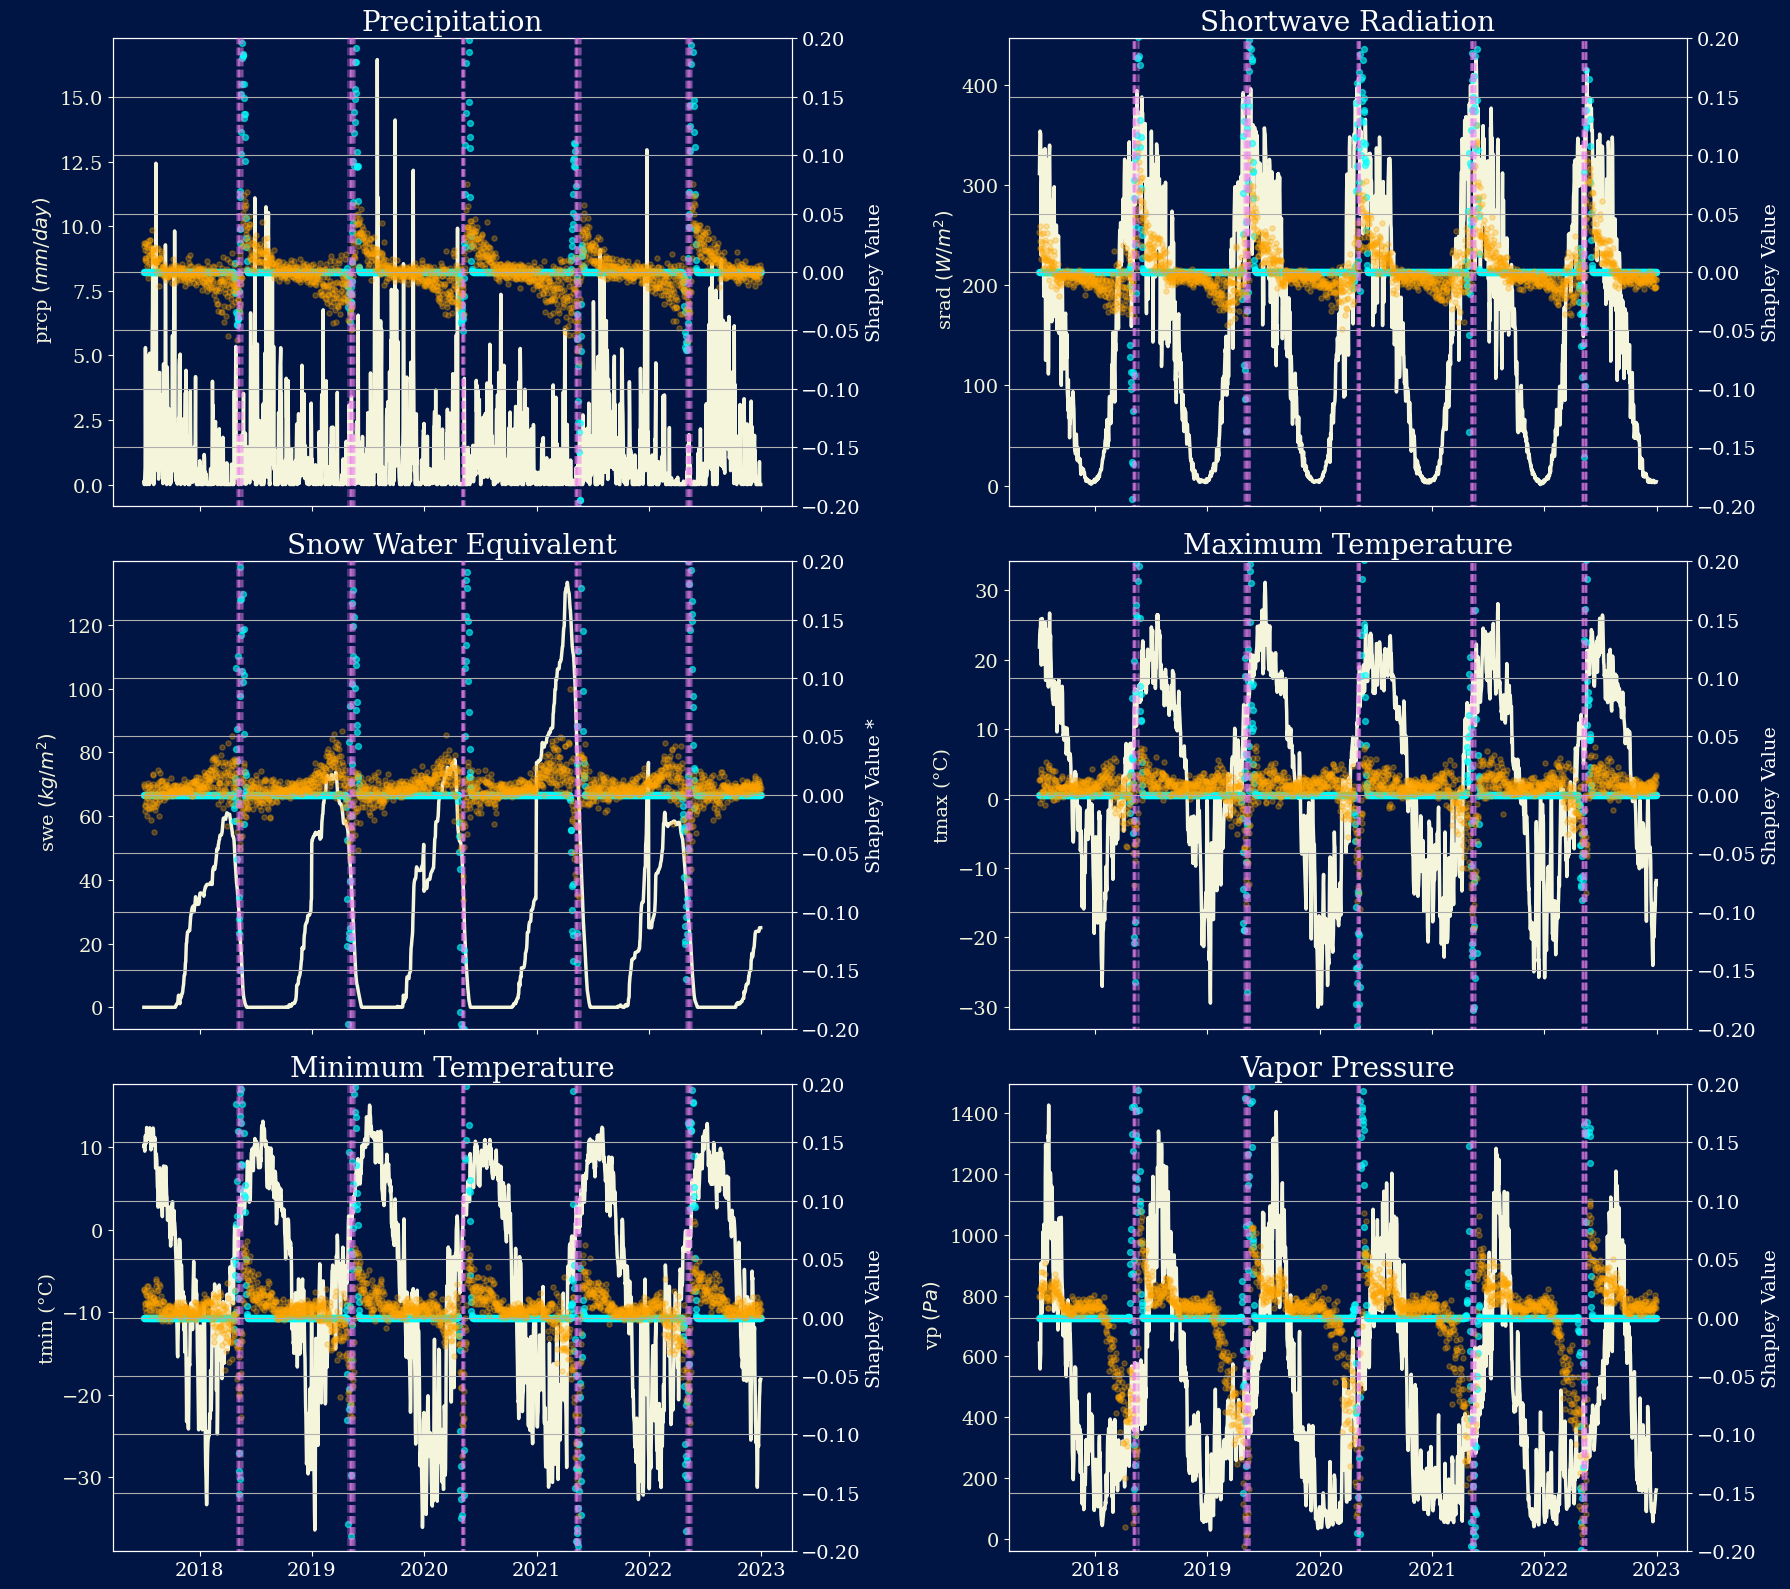

In [18]:
STYLE = 'poster'
presentation_vs_poster(STYLE)
# plt.rcParams.update({"font.family" : "serif"})

normed = False
LEGEND = False

fig, axs = plt.subplots(figsize = (18, 16), nrows=3, ncols=2, sharey = False, sharex=True)
# fig.set_size_inches(w=15, h=7)

plt.subplots_adjust(hspace=0.2)
# fig.suptitle("Shapley Scores Relative to E[Variables | Location] Over Time", fontsize=plot_title_size, fontweight='bold', y=0.96, color = general_text_color)
axs = axs.ravel()
fig.patch.set_facecolor(FACECOLOR)

for IDX, (ax, var) in enumerate(zip(axs, variables_in_question)):
    ax.set_title(variable_names[IDX], fontsize = large_font_size, color = general_text_color)
    
    if normed:
        plot_var = plot_df[var]
    else:
        plot_var = (plot_df[var]*(mins_and_maxes['maxes'][var] - mins_and_maxes['mins'][var])) + mins_and_maxes['mins'][var]
    
    ax.plot(plot_df.dates,
            plot_var,
            color = first_axs_col,
            linewidth = 2.5)
    ax.tick_params(axis='y', colors=first_axs_col)
    
    varname = var.split('(')
    
    if varname[0].startswith('tm'):
        degree_symbol = '\u00b0'
        ax.set_ylabel(varname[0] + ' (' + degree_symbol + 'C)', color = first_axs_col, fontsize = small_font_size, fontweight='regular')
    else:
        units = f'$({varname[1]}$'
        ax.set_ylabel(f'\n {varname[0]} {units}', color = first_axs_col, fontsize = small_font_size, fontweight='regular')
    
    ax.set_facecolor(FACECOLOR)
    
    ax2 = ax.twinx()
    ax2.set_ylim([-0.2, 0.2])
    ax2.scatter(plot_df.dates, plot_df[var+'_shap_value'], color = 'cyan', alpha = 0.6, s = medium_font_size, label = 'Biased')
    ax2.scatter(plot_df.dates, plot_df[var+'_shap_value_NB'], color = 'orange', alpha = 0.3, s = small_font_size, label = 'Not Biased')

    ax2.tick_params(axis='y', colors=general_text_color)
    if variable_names[IDX].upper() == 'SNOW WATER EQUIVALENT':
        ax2.set_ylabel('Shapley Value *', color = general_text_color, fontsize = small_font_size)
    else:
        ax2.set_ylabel('Shapley Value', color = general_text_color, fontsize = small_font_size)
    
    ax2.vlines(plot_df.dates[plot_df.Predicted_Dates.astype('bool')],
                ymin = plot_df[var+'_shap_value'].min(),
                ymax = plot_df[var+'_shap_value'].max(),
                color = 'violet',
                linestyles = 'dashed',
                linewidth = 1.5,
                alpha=0.3,
                zorder = 3) # actual
    ax2.grid()
    
    if IDX == 0 and LEGEND:
        
        legend = fig.legend(frameon=True, labelspacing=1, title = 'Shapley Values', loc = 'upper right', fontsize=large_font_size, bbox_to_anchor=(1.0, 0.9))
        legend.get_title().set_fontsize(large_font_size)
        legend.legendHandles[0]._sizes = [10*small_font_size]
        legend.legendHandles[1]._sizes = [10*small_font_size]

plt.tight_layout()
if save_image:
    plt.savefig(f'/mnt/locutus/remotesensing/r62/river_ice_breakup/Images/Daymet_Results/Daymet_shapley_values_{STYLE}.png', dpi = 350)